# Group Members
- **Sergio Pozuelo Martín-Consuegra**
- **Alberto Barrais Bellerín**
- **Alejandro del Hoyo Abad**

# Task statement

In this task, we will develop predictive models to estimate the probability of individuals receiving two different types of vaccines: the H1N1 flu vaccine and the seasonal flu vaccine. In this case, the following csv files are provided in order to carry out the problem: 
- **Training features**: these are the inputs variables that will be used to predict the probability that a person have received the H1N1 flu and/or the seasonal flu vaccines. In this case, there is a total of 35 features, each being a response to a survey question. Moreover, these questions cover different topics such as: their opinion of the vaccines, their sex, their behavior or their demographic among others. 

- **Training labels**: these are the target variables that indicate whether a person has received the H1N1 flu vaccine and/or the seasonal flu vaccine. There are two columns in this file: `h1n1_vaccine` and `seasonal_vaccine`, each containing binary values (0 or 1) indicating the absence or presence of the respective vaccine. For instance, this problem is a multilabel modeling task because, as it has been mentioned before, each person can be associated with multiple vaccines. 

- **Test features**: these test features will be used to generate the submission predictions after the model has been traing. Then this test features are not labeled.



# Import csv files

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier

from sklearn.pipeline import Pipeline



In [2]:
train_df =  pd.read_csv("training_set_features.csv", index_col="respondent_id")
test_df =  pd.read_csv("test_set_features.csv", index_col="respondent_id")
labels_df = pd.read_csv("training_set_labels.csv", index_col="respondent_id")


In this case, we join the train set and labels so that we can view correlations and feature importance. Morover, we don't take into account missing values

In [3]:
joined_dataframe = train_df.join(labels_df)
print(joined_dataframe.shape)
joined_dataframe.head()

(26707, 37)


,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Exploratory data analysis

Firslty, we are going to check all the main features of the dataset. In this case, we have the following: 


In [4]:
# Check the unique values of each of the classes
display(joined_dataframe.nunique())

h1n1_concern                    4
h1n1_knowledge                  3
behavioral_antiviral_meds       2
behavioral_avoidance            2
behavioral_face_mask            2
behavioral_wash_hands           2
behavioral_large_gatherings     2
behavioral_outside_home         2
behavioral_touch_face           2
doctor_recc_h1n1                2
doctor_recc_seasonal            2
chronic_med_condition           2
child_under_6_months            2
health_worker                   2
health_insurance                2
opinion_h1n1_vacc_effective     5
opinion_h1n1_risk               5
opinion_h1n1_sick_from_vacc     5
opinion_seas_vacc_effective     5
opinion_seas_risk               5
opinion_seas_sick_from_vacc     5
age_group                       5
education                       4
race                            4
sex                             2
income_poverty                  3
marital_status                  2
rent_or_own                     2
employment_status               3
hhs_geo_region

In [5]:
# Count the number of element that each column has in each class
for column in joined_dataframe.columns: 
    if joined_dataframe[column].nunique() == 2: # For those columns who have exactly two unique values
        display(joined_dataframe[column].value_counts()) # Show all the values

behavioral_antiviral_meds
0.0    25335
1.0     1301
Name: count, dtype: int64

behavioral_avoidance
1.0    19228
0.0     7271
Name: count, dtype: int64

behavioral_face_mask
0.0    24847
1.0     1841
Name: count, dtype: int64

behavioral_wash_hands
1.0    22015
0.0     4650
Name: count, dtype: int64

behavioral_large_gatherings
0.0    17073
1.0     9547
Name: count, dtype: int64

behavioral_outside_home
0.0    17644
1.0     8981
Name: count, dtype: int64

behavioral_touch_face
1.0    18001
0.0     8578
Name: count, dtype: int64

doctor_recc_h1n1
0.0    19139
1.0     5408
Name: count, dtype: int64

doctor_recc_seasonal
0.0    16453
1.0     8094
Name: count, dtype: int64

chronic_med_condition
0.0    18446
1.0     7290
Name: count, dtype: int64

child_under_6_months
0.0    23749
1.0     2138
Name: count, dtype: int64

health_worker
0.0    23004
1.0     2899
Name: count, dtype: int64

health_insurance
1.0    12697
0.0     1736
Name: count, dtype: int64

sex
Female    15858
Male      10849
Name: count, dtype: int64

marital_status
Married        13555
Not Married    11744
Name: count, dtype: int64

rent_or_own
Own     18736
Rent     5929
Name: count, dtype: int64

h1n1_vaccine
0    21033
1     5674
Name: count, dtype: int64

seasonal_vaccine
0    14272
1    12435
Name: count, dtype: int64

In [6]:
for column in joined_dataframe.columns: 
    if joined_dataframe[column].nunique() > 2: # For those columns who have more than two unique values
        display(joined_dataframe[column].value_counts())

h1n1_concern
2.0    10575
1.0     8153
3.0     4591
0.0     3296
Name: count, dtype: int64

h1n1_knowledge
1.0    14598
2.0     9487
0.0     2506
Name: count, dtype: int64

opinion_h1n1_vacc_effective
4.0    11683
5.0     7166
3.0     4723
2.0     1858
1.0      886
Name: count, dtype: int64

opinion_h1n1_risk
2.0    9919
1.0    8139
4.0    5394
5.0    1750
3.0    1117
Name: count, dtype: int64

opinion_h1n1_sick_from_vacc
2.0    9129
1.0    8998
4.0    5850
5.0    2187
3.0     148
Name: count, dtype: int64

opinion_seas_vacc_effective
4.0    11629
5.0     9973
2.0     2206
1.0     1221
3.0     1216
Name: count, dtype: int64

opinion_seas_risk
2.0    8954
4.0    7630
1.0    5974
5.0    2958
3.0     677
Name: count, dtype: int64

opinion_seas_sick_from_vacc
1.0    11870
2.0     7633
4.0     4852
5.0     1721
3.0       94
Name: count, dtype: int64

age_group
65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: count, dtype: int64

education
College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: count, dtype: int64

race
White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: count, dtype: int64

income_poverty
<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: count, dtype: int64

employment_status
Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: count, dtype: int64

hhs_geo_region
lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: count, dtype: int64

census_msa
MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: count, dtype: int64

household_adults
1.0    14474
0.0     8056
2.0     2803
3.0     1125
Name: count, dtype: int64

household_children
0.0    18672
1.0     3175
2.0     2864
3.0     1747
Name: count, dtype: int64

employment_industry
fcxhlnwr    2468
wxleyezf    1804
ldnlellj    1231
pxcmvdjn    1037
atmlpfrs     926
arjwrbjb     871
xicduogh     851
mfikgejo     614
vjjrobsf     527
rucpziij     523
xqicxuve     511
saaquncn     338
cfqqtusy     325
nduyfdeo     286
mcubkhph     275
wlfvacwt     215
dotnnunm     201
haxffmxo     148
msuufmds     124
phxvnwax      89
qnlwzans      13
Name: count, dtype: int64

employment_occupation
xtkaffoo    1778
mxkfnird    1509
emcorrxb    1270
cmhcxjea    1247
xgwztkwe    1082
hfxkjkmi     766
qxajmpny     548
xqwwgdyp     485
kldqjyjy     469
uqqtjvyb     452
tfqavkke     388
ukymxvdu     372
vlluhbov     354
oijqvulv     344
ccgxvspp     341
bxpfxfdn     331
haliazsg     296
rcertsgn     276
xzmlyyjv     248
dlvbwzss     227
hodpvpew     208
dcjcmpih     148
pvmttkik      98
Name: count, dtype: int64

In [7]:
# Show missisng and duplicate values
missing_values = joined_dataframe.isnull().sum()
duplicate_values = joined_dataframe.duplicated().sum

display(missing_values)
print()
display(duplicate_values)

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

<bound method NDFrame._add_numeric_operations.<locals>.sum of respondent_id
0        False
1        False
2        False
3        False
4        False
         ...  
26702    False
26703    False
26704    False
26705    False
26706    False
Length: 26707, dtype: bool>

### Check whether the classes are balanced or not

### H1N1 vaccine

<Axes: xlabel='h1n1_vaccine', ylabel='count'>

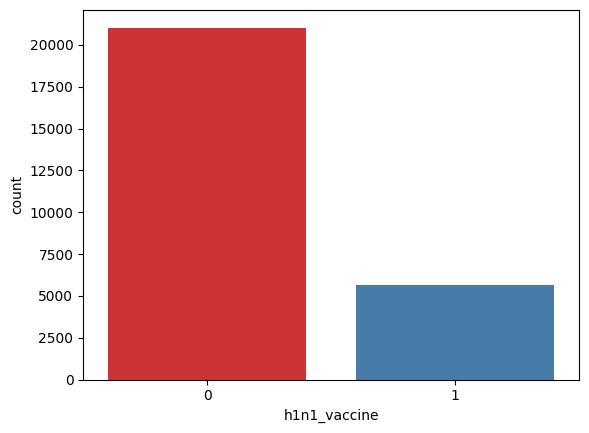

In [8]:
sns.countplot(x=labels_df.h1n1_vaccine, hue=labels_df.h1n1_vaccine, data=labels_df, palette='Set1', legend=False)

As illustrated in the image, the number of individuals who have not received the H1N1 vaccine is approximately four times greater than those who have. Therefore, this indicates that the H1N1 flu vaccine target exhibits a moderately imbalanced class distribution.

### Seasonal vaccine

<Axes: xlabel='seasonal_vaccine', ylabel='count'>

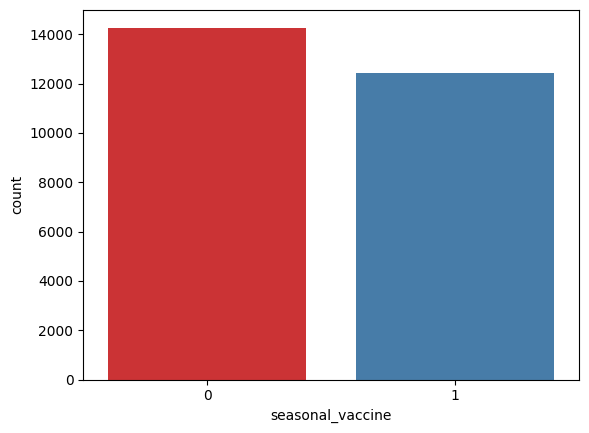

In [9]:
sns.countplot(x=labels_df.seasonal_vaccine, hue=labels_df.seasonal_vaccine, data=labels_df, palette='Set1', legend=False)

In this case, unlike the previous scenario, the difference between the number of individuals who have received the seasonal flu vaccine and those who have not is relatively small. Therefore, we can conclude that the seasonal flu vaccine target has a balanced class distribution.

### Relation between features of the dataset

In this section, we will analyze the key characteristics of this dataset, with a particular focus on the correlations between its significant features. To achieve this, we will visualize the various features and compare their proportions in relation to the vaccines. This approach will help us identify the most influential factors within the dataset.

In [10]:
def plot_vaccination_rate(feature_col, target_col, dataframe, ax=None):
    """
    Creates horizontal satcked bar chart
    showing vaccination rate for 
    the target variable against a feature variable
    """

    # Calculate counts for each combination of target and feature values
    counts = (joined_dataframe[[target_col, feature_col]].groupby([target_col, feature_col]).size().unstack(target_col))
    group_counts = counts.sum(axis='columns')
    proportions = counts.div(group_counts, axis='index')

    proportions.plot(kind="barh", stacked=True, ax=ax, alpha=0.8, color = ['green', 'red'])
    ax.legend().remove()


In [11]:
# Loop through all the columns 

def plot_all_vaccination_rates(columns_to_plot):
    """
    Plots vaccination rates for all specified columns
    """
 # Create a figure with appropriate number of subplots
    fig, axes = plt.subplots(len(columns_to_plot), 2, figsize=(9,len(columns_to_plot)*5))
    
    # Loop through columns and plot
    for index, column in enumerate(columns_to_plot):
        # Plot H1N1 vaccination rate
        plot_vaccination_rate(column, "h1n1_vaccine", joined_dataframe, ax=axes[index, 0])
        axes[index, 0].legend().remove()  
        axes[index, 0].set_title(f"H1N1 Vaccine vs {column}")
        
        # Plot Seasonal vaccination rate
        plot_vaccination_rate(column, "seasonal_vaccine", joined_dataframe, ax=axes[index, 1])
        axes[index, 1].legend().remove()  
        axes[index, 1].set_title(f"Seasonal Vaccine vs {column}")
    
    axes[0, 0].legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), title="h1n1_vaccine")
    axes[0, 1].legend(loc="lower center", bbox_to_anchor=(0.5, 1.05), title="seasonal_vaccine")
    fig.tight_layout()

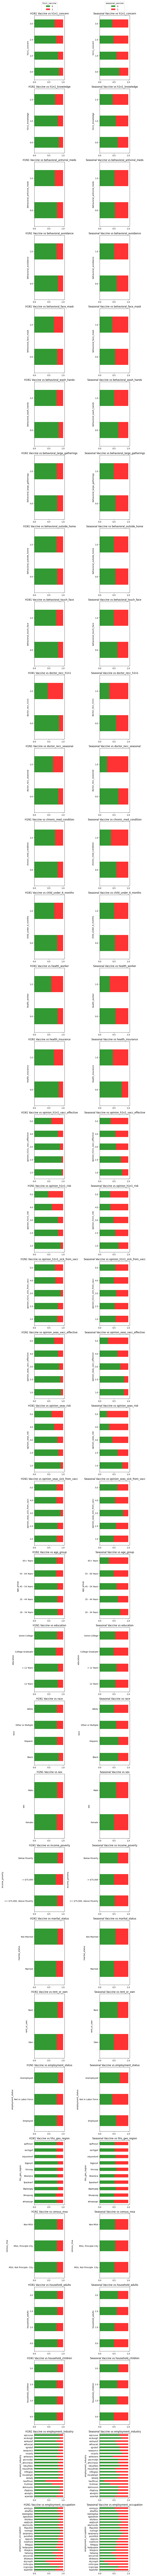

In [12]:
columns_to_plot = []
for columns in train_df.columns:
    columns_to_plot.append(columns)

plot_all_vaccination_rates(columns_to_plot)

In this case, as shown in the graphics, we can highlight that demographic features such as sex, age group, and race have a strong correlation with the seasonal vaccine, particularly within the age group. For instance, The data indicates that the higher the age, the bigger is the proportion of people who have received this vaccine. However, when it comes to the H1N1 vaccine, the correlation in this context appears much weaker in where it is interesting to see that there is a higher proportion of people in the group of 55-64 year than in the one of people who are older than 65.

Moreover, for both types of vaccines, it is notable that the proportion of individuals who have received the respective vaccine is higher in certain features, such as: the respondent's opinion on the effectiveness of the seasonal flu vaccine, their perception of the risk of contracting seasonal flu without the vaccine, their opinion on the risk of contracting H1N1 without the vaccine, and their view on the effectiveness of the H1N1 vaccine. In this sense, this means that individuals' perceptions about their vulnerability to illness and the efficacy of the vaccine influence, to some extent, their decision to get vaccinated.

## Training models to obtain the best results


In this section, we will explore different algorithms to achieve the best ROC AUC score. In this case, the ROC AUC (Receiver Operating Characteristic - Area Under the Curve) is a metric used to evaluate the performance of a binary classification model which provides a visual representation of the model's ability to distinguish between classes, with higher scores indicating better performance.

Then, in order to carry out this, the following function will be used to plot the corresponding ROC AUC score.

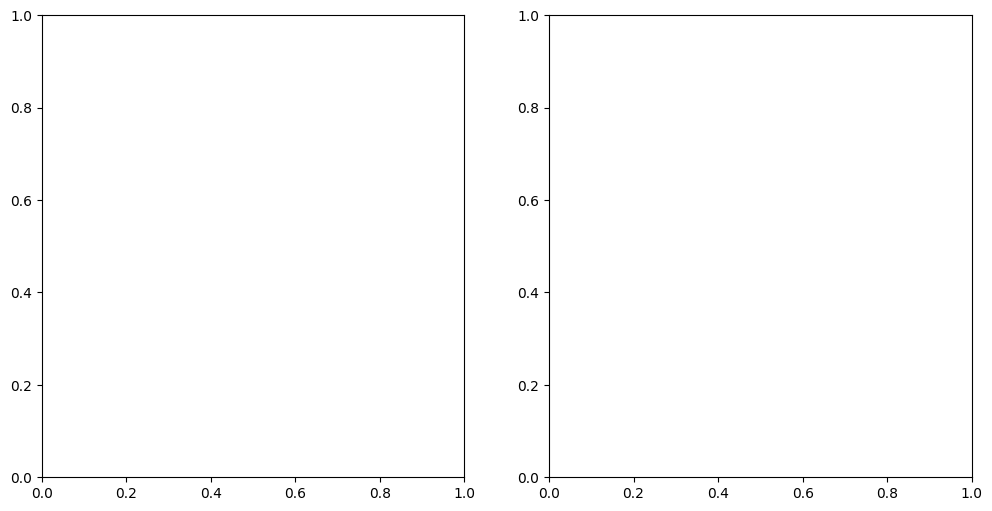

In [ ]:
# Define a function to plot ROC
def plot_roc(y_true, y_score, label_name, ax):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    ax.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    ax.set_title(f"ROC Curve for {label_name}")
    ax.legend(loc="lower right")

# Create subplots for the ROC curves
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))


# # Plot ROC for H1N1 Vaccine
# plot_roc(y_h1n1_val, y_h1n1_val_probs, 'H1N1 Vaccine', ax=ax[0])

# # Plot ROC for Seasonal Vaccine
# plot_roc(y_seasonal_val, y_seasonal_val_probs, 'Seasonal Vaccine', ax=ax[1])

# # Adjust layout and display the plot
# fig.tight_layout()
# plt.show()

# # Calculate average AUC for competition metric
# y_eval = np.column_stack((y_h1n1_val, y_seasonal_val))
# y_probs = np.column_stack((y_h1n1_val_probs, y_seasonal_val_probs))
# average_auc = roc_auc_score(y_eval, y_probs, average="macro")
# # Average ROC aucs
# print(f"Average ROC AUC: {average_auc:.4f}")

# # Final training on the full training set
# rf_h1n1.fit(X, y_h1n1)
# rf_seasonal.fit(X, y_seasonal)
    
